In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import numpy as np
from matplotlib import pyplot as plt
import torch
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL
from sparse_causal_model_learner_rl.config import Config
from keychest.features_xy import arr_to_dict, dict_to_arr, obs_features_handcoded
from keychest.gofa_model import manual_model_features
from sparse_causal_model_learner_rl.trainable.gumbel_switch import LearnableSwitch, WithInputSwitch
from tqdm.auto import tqdm
from torch import nn
import gin

In [2]:
%%javascript
var jq = document.createElement('script');
jq.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(jq);

<IPython.core.display.Javascript object>

In [3]:
%load_ext jupyternotify
%autonotify -a 30

<IPython.core.display.Javascript object>

In [4]:
gin.enter_interactive_mode()

In [5]:
load_config_files(['../keychest/config/5x5_1f1c1k.gin', '../sparse_causal_model_learner_rl/configs/rec_nonlin_gnn.gin'])

['5x5_1f1c1k', 'rec_nonlin_gnn']

In [6]:
gin.bind_parameter('Config.env_steps', 10000)
gin.bind_parameter('Config.shuffle', True)

In [8]:
learner = CausalModelLearnerRL(Config())

2021-01-26 00:15:50,724	INFO worker.py:651 -- Connecting to existing Ray cluster at address: 172.26.71.6:6379


Selecting name 43b35c70-5f63-11eb-be30-f7c3ec0edd26
Make environment KeyChest-v0 None {}


In [9]:
learner.collect_steps()

In [10]:
_ = learner._context
oa_x = torch.cat([learner._context_cache['obs_x'], learner._context_cache['action_x']], dim=1)
o_y = learner._context_cache['obs_y']

In [11]:
assert oa_x.shape[1] == 17 + 4
assert o_y.shape[1] == 17
assert oa_x.shape[0] == o_y.shape[0]

In [99]:
model_o = torch.nn.Sequential(*[
    torch.nn.Linear(21, 200),
    torch.nn.ReLU(),
    torch.nn.Linear(200, 200),
    torch.nn.ReLU(),
    torch.nn.Linear(200, 200),
    torch.nn.ReLU(),
    torch.nn.Linear(200, 17),
]).to(learner.device)

In [100]:
params = model_o.parameters()
opt = torch.optim.Adam(params=model_o.parameters(), lr=1e-2)#, amsgrad=True)
# opt = torch.optim.LBFGS(model_o.parameters())
# opt = torch.optim.RMSprop(params, lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=.5, centered=False)

In [101]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=50,
                                                 threshold=0.0001, threshold_mode='rel', cooldown=0,
                                                 min_lr=0, eps=1e-08, verbose=True)

In [102]:
def loss(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    delta = y_true - y_pred
    delta = torch.abs(delta)
    delta = delta.pow(2)
    delta = delta.mean(axis=0)
    delta = delta.mean()
    return delta

In [103]:
losses = []

In [104]:
def closure():
    y_pred = model_o(oa_x)
    y_true = o_y
    l = loss(y_true, y_pred)
    return l

In [131]:
for epoch in tqdm(range(50000)):
    opt.zero_grad()

    l = closure()

    l.backward()
    opt.step()#closure)
    
#     l = closure()
    losses.append(l.item())
    
    scheduler.step(l)

Epoch 74981: reducing learning rate of group 0 to 4.8828e-06.



<IPython.core.display.Javascript object>

In [119]:
scheduler._last_lr[0]

7.8125e-05

In [134]:
l

tensor(3.1223e-06, grad_fn=<MeanBackward0>)

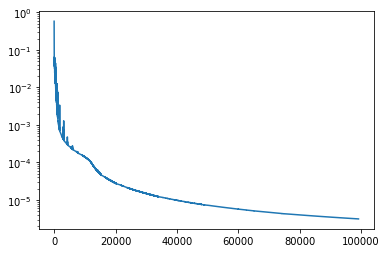

In [132]:
plt.plot(losses)
plt.yscale('log')

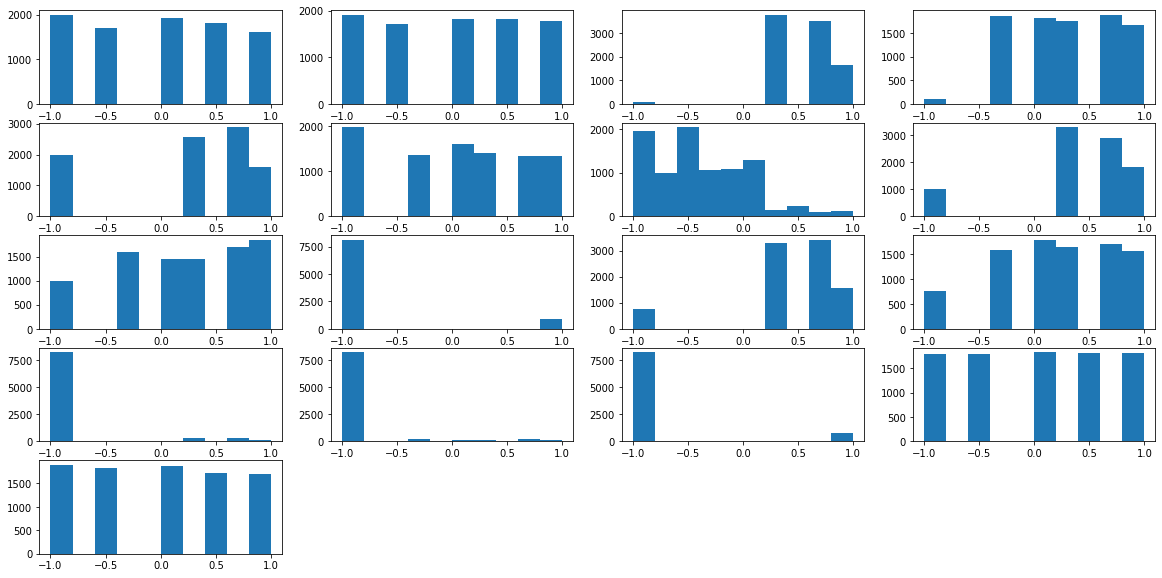

In [45]:
plt.figure(figsize=(20, 10))
for i in range(o_y.shape[1]):
    plt.subplot(5, 4, i + 1)
    plt.hist(o_y[:, i].numpy())
plt.show()

# Manual testing...

In [5]:
gin.enter_interactive_mode()
load_config_files(['../keychest/config/5x5_1f1c1k.gin', '../sparse_causal_model_learner_rl/configs/rec_nonlin_gnn.gin'])

gin.bind_parameter('Config.env_steps', 10000)
gin.bind_parameter('Config.shuffle', True)
# gin.bind_parameter('Config.context_transforms', [])
#learner.config.get('')

learner = CausalModelLearnerRL(Config())
learner.collect_steps()

Make environment KeyChest-v0 None {}


In [6]:
all_keys = obs_features_handcoded(learner.env.engine, learner.env.engine._observation).keys()

In [7]:
# important: _context changes (shuffle every time...)
ctx = learner._context
fx = learner._context_cache['obs_x'].numpy().copy()
fy = learner._context_cache['obs_y'].numpy().copy()
ax = learner._context_cache['action_x'].numpy().copy()

In [8]:
def compute_delta(fx, fy, ax, learner):
    fx_denorm = fx * (learner.normalizers['obs'].std + 1e-10) + learner.normalizers['obs'].mean
    fy_denorm = fy * (learner.normalizers['obs'].std + 1e-10) + learner.normalizers['obs'].mean
    ax_denorm = ax * (learner.normalizers['action_x'].std + 1e-10) + learner.normalizers['action_x'].mean
    
    fx_dict = [arr_to_dict(f, all_keys) for f in fx_denorm]
    fy_dict = [arr_to_dict(f, all_keys) for f in fy_denorm]

    deltas = [dict_to_arr(manual_model_features(fxd, axd, learner.env.engine)) - fyd for (fxd, axd, fyd) in zip(fx_dict, ax_denorm, fy_denorm)]
    
    return np.array(deltas)

In [9]:
deltas = compute_delta(fx, fy, ax, learner)

In [10]:
d1 = np.max(np.abs(np.array(deltas)), axis=0)
d1, np.max(d1)

(array([0.0000000e+00, 0.0000000e+00, 4.7683716e-07, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 2.3841858e-07, 0.0000000e+00,
        2.3841858e-07, 0.0000000e+00, 4.7683716e-07, 2.3841858e-07,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00], dtype=float32),
 4.7683716e-07)

In [11]:
### dict(zip(sorted(all_keys), d1))

In [12]:
norms = np.linalg.norm(deltas, axis=1)

In [13]:
norms[norms > 1e-5]

array([], dtype=float32)

In [35]:
idxes_bad = np.where(norms > 1e-5)[0]
idx_bad = idxes_bad[0]

In [38]:
fx_denorm = fx# * (learner.normalizers['obs'].std + 1e-10) + learner.normalizers['obs'].mean
fy_denorm = fy# * (learner.normalizers['obs'].std + 1e-10) + learner.normalizers['obs'].mean
ax_denorm = ax# * (learner.normalizers['action_x'].std + 1e-10) + learner.normalizers['action_x'].mean

fx_dict = [arr_to_dict(f, all_keys) for f in fx_denorm]
fy_dict = [arr_to_dict(f, all_keys) for f in fy_denorm]


In [39]:
fx_dict[idx_bad], ax_denorm[idx_bad], fy_dict[idx_bad], dict(zip(sorted(all_keys), deltas[idx_bad]))

({'button__x': 6.0,
  'button__y': 2.0,
  'chest__00__x': 9.0,
  'chest__00__y': 5.0,
  'food__00__x': 6.0,
  'food__00__y': 4.0,
  'health': 7.0,
  'key__00__x': 6.0,
  'key__00__y': 5.0,
  'keys': 0.0,
  'lamp_off__x': 9.0,
  'lamp_off__y': 2.0,
  'lamp_on__x': -1.0,
  'lamp_on__y': -1.0,
  'lamp_status': 0.0,
  'player__x': 5.0,
  'player__y': 4.0},
 array([1., 0., 0., 0.], dtype=float32),
 {'button__x': 7.0,
  'button__y': 5.0,
  'chest__00__x': 5.0,
  'chest__00__y': 5.0,
  'food__00__x': 7.0,
  'food__00__y': 2.0,
  'health': 4.0,
  'key__00__x': 9.0,
  'key__00__y': 4.0,
  'keys': 0.0,
  'lamp_off__x': 8.0,
  'lamp_off__y': 1.0,
  'lamp_on__x': -1.0,
  'lamp_on__y': -1.0,
  'lamp_status': 0.0,
  'player__x': 9.0,
  'player__y': 3.0},
 {'button__x': -1.0,
  'button__y': -3.0,
  'chest__00__x': 4.0,
  'chest__00__y': 0.0,
  'food__00__x': -1.0,
  'food__00__y': 2.0,
  'health': 2.0,
  'key__00__x': -3.0,
  'key__00__y': 1.0,
  'keys': 0.0,
  'lamp_off__x': 1.0,
  'lamp_off__y': 1.

In [40]:
idx_bad

0

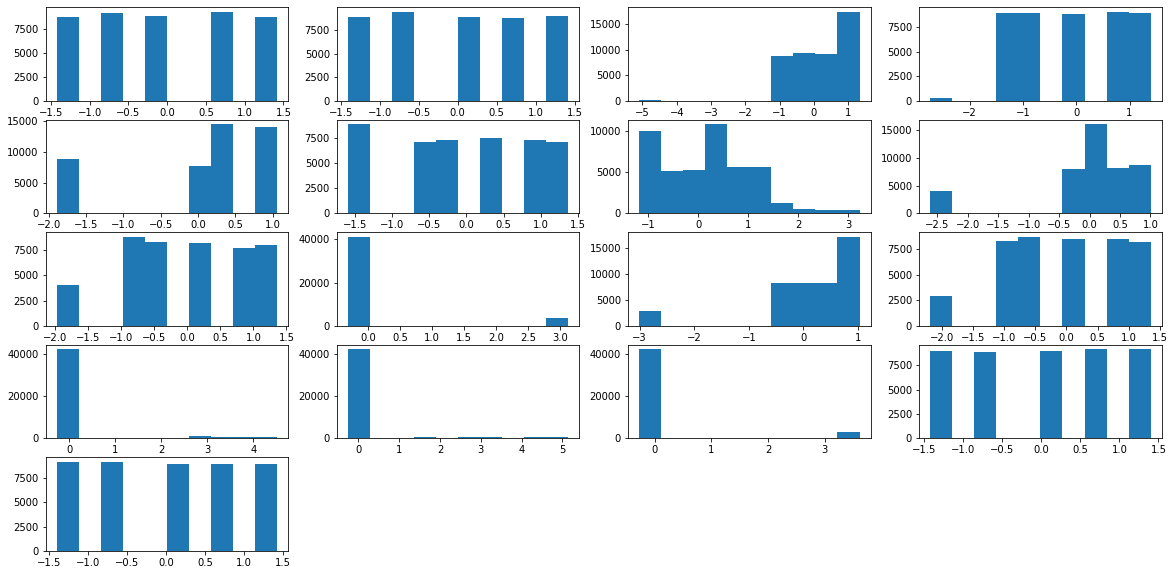

In [184]:
plt.figure(figsize=(20, 10))
for i in range(fx.shape[1]):
    plt.subplot(5, 4, i + 1)
    plt.hist(fx[:, i])
plt.show()

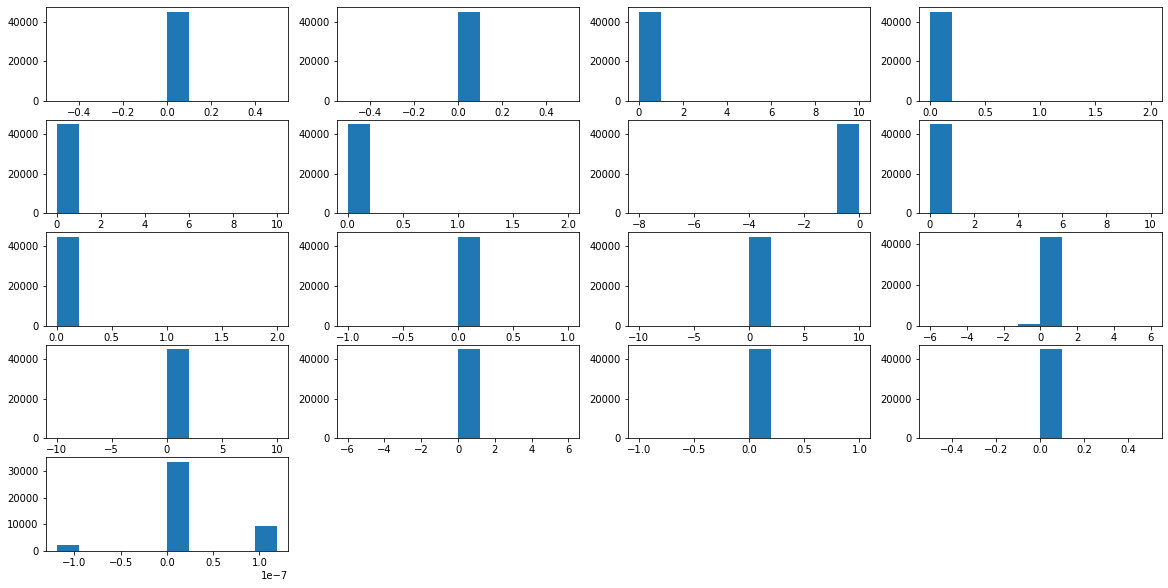

In [178]:
deltas = np.array(deltas)

plt.figure(figsize=(20, 10))
for i in range(fx.shape[1]):
    plt.subplot(5, 4, i + 1)
    plt.hist(deltas[:, i])
plt.show()

(array([1.07000e+02, 2.59000e+02, 1.57000e+02, 1.41000e+02, 8.59700e+03,
        7.56919e+05, 4.19000e+02, 1.02000e+02, 2.59000e+02, 3.52000e+02]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.],
       dtype=float32),
 <BarContainer object of 10 artists>)

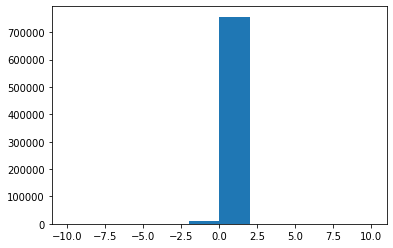

In [179]:
plt.hist(np.array(deltas).flatten())

(array([0.0000000e+00, 0.0000000e+00, 1.0000000e+01, 2.0000000e+00,
        1.0000000e+01, 2.0000000e+00, 8.0000000e+00, 1.0000000e+01,
        2.0000000e+00, 1.0000000e+00, 1.0000000e+01, 6.0000000e+00,
        1.0000000e+01, 5.9999995e+00, 1.0000000e+00, 0.0000000e+00,
        1.1920929e-07], dtype=float32),
 10.0)

In [110]:
sorted(k, )

['button__x',
 'button__y',
 'chest__00__x',
 'chest__00__y',
 'food__00__x',
 'food__00__y',
 'health',
 'key__00__x',
 'key__00__y',
 'keys',
 'lamp_off__x',
 'lamp_off__y',
 'lamp_on__x',
 'lamp_on__y',
 'lamp_status',
 'player__x',
 'player__y']

In [111]:
np.array(deltas).shape

(9032, 17)

In [55]:
learner.shuffle_together

[['obs_x', 'obs_y', 'action_x', 'reward_to_go'], ['obs']]

In [35]:
self = learner

In [36]:
context = learner._context_subclass

In [37]:
{x: len(y) for x, y in context.items() if isinstance(y, np.ndarray)}

{'obs_x': 9016,
 'obs_y': 9016,
 'action_x': 9016,
 'obs': 10002,
 'reward_to_go': 9016}

In [38]:
for group in self.shuffle_together:
    idx = list(range(len(context[group[0]])))
    np.random.shuffle(idx)
    print('shuffling', group)
    for key in group:
        context[key] = np.array(context[key])[idx]

shuffling ['obs_x', 'obs_y', 'action_x', 'reward_to_go']
shuffling ['obs']


In [99]:
len(idx)

10003

In [100]:
{x: len(y) for x, y in context.items() if isinstance(y, np.ndarray)}

{'obs_x': 9032,
 'obs_y': 9032,
 'action_x': 9032,
 'obs': 10003,
 'reward_to_go': 9032}

In [102]:
A = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

In [104]:
A[[0, 2, 1]]

array([[1, 2, 3],
       [7, 8, 9],
       [4, 5, 6]])

# Try symbolic regression

In [31]:
gin.bind_parameter('Config.context_transforms', [])
learner = CausalModelLearnerRL(Config())
learner.collect_steps()
_ = learner._context
oa_x = torch.cat([learner._context_cache['obs_x'], learner._context_cache['action_x']], dim=1)
o_y = learner._context_cache['obs_y']

2021-01-26 00:22:14,126	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 283b7cba-5f64-11eb-be30-f7c3ec0edd26
Make environment KeyChest-v0 None {}


In [32]:
max_n = 1000
oa_x_np = oa_x.numpy()[:max_n]
o_y_np = o_y.numpy()[:max_n]

In [33]:
o_y_np

array([[6., 3., 7., ..., 1., 9., 2.],
       [5., 2., 5., ..., 0., 8., 2.],
       [8., 1., 8., ..., 0., 7., 3.],
       ...,
       [6., 4., 9., ..., 0., 7., 2.],
       [8., 4., 7., ..., 0., 7., 1.],
       [5., 3., 5., ..., 0., 6., 3.]], dtype=float32)

In [34]:
all_keys = obs_features_handcoded(learner.env.engine, learner.env.engine._observation).keys()

In [57]:
idx_out = sorted(all_keys).index('player__x')
idx_out

15

In [46]:
len(all_keys)

17

In [58]:
# reg_use_x = oa_x_np[:, [idx_out, 17, 18, 19, 20]]

In [59]:
from pysr import pysr, best, get_hof

# Learn equations
equations = pysr(oa_x_np, o_y_np[:, idx_out], niterations=50, procs=10, select_k_features=4,
    binary_operators=["plus", "mult", "max", "min"],#, "logical_or", "logical_and", "greater"],
    unary_operators=[
#         "neg", "sign",
    ])
#       "cos", "exp", "sin", #Pre-defined library of operators (see https://pysr.readthedocs.io/en/latest/docs/operators/)
#       "inv(x) = 1/x"]) # Define your own operator! (Julia syntax)

print(best(equations))


Using features [ 0 15 17 18]
Running on julia -O3 -p 10 /tmp/tmpl_r2wppw/runfile.jl
Started!

Cycles per second: 6.000e+04
Progress: 10 / 500 total iterations (2.000%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           1.981e+00  0.000e+00  6.970000
7           9.344e-02  4.363e-01  plus(plus(x1, mult(-0.7480452, x3)), x2)
9           8.635e-02  3.945e-02  plus(plus(mult(x3, -0.7517581), min(x2, 0.8243947)), x1)
11          8.635e-02  -0.000e+00  plus(plus(min(mult(x3, -0.7517581), x1), min(x2, 0.8243947)), x1)
15          6.464e-02  7.240e-02  plus(mult(plus(mult(x3, 1.7291627), x2), mult(x1, -0.06507221)), plus(mult(x2, 1.0756866), x1))
17          5.174e-02  1.113e-01  plus(mult(mult(plus(mult(x3, 1.0489794), min(0.30432588, x2)), -0.1567073), plus(x1, -2.324804)), plus(x1, x2))
19          5.170e-02  3.684e-04  plus(mult(mult(plus(mult(x3, 1.0899194), min(0.30432588, x2)), -0.1567073), plus(plus(x1, -1.7399848), -0.55334836

<IPython.core.display.Javascript object>